# NEAT

- **N**euro**E**volution of **A**ugmenting **T**opologies
- Evolves network topologies (hyper parameter) and connection weights (parameters) simultaneously
- Based on Reinforcement Learning
- Application areas: playing games, game AI, developing evacuation models, vehicle warning system
- Most popular neuroevolution approach but others exist as well

## XOR-Problem

We want to evolve a network capable of representing an XOR-Gate:

In [1]:
from __future__ import annotations
import pandas as pd

from IPython.display import HTML
xor = [[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 0]]
xor_df = pd.DataFrame(xor, columns=["Input1", "Input2", "Output"])
HTML(xor_df.to_html(index=False))

Input1,Input2,Output
0,0,0
0,1,1
1,0,1
1,1,0


The XOR-Problem is a __binary classification problem__, which cannot be solved using a linear separation line.

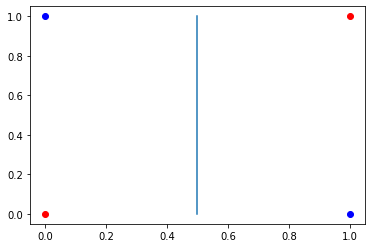

In [2]:
import matplotlib.pyplot as plt

zero_x = [0, 1]
zero_y = [0, 1]
one_x = [0, 1]
one_y = [1, 0]

# Plot XOR-Dots
plt.scatter(zero_x, zero_y, color='red')
plt.scatter(one_x, one_y, color='blue')

# Try out different separation lines
#plt.plot(zero_x, one_y)
#plt.plot(one_x, zero_y)
plt.plot([0.5, 0.5], [0, 1])
#plt.plot([0, 1], [0.5, 0.5])
plt.show()

Since we need a __non linear__ separation line, NEAT has to evolve networks with at least one hidden node.

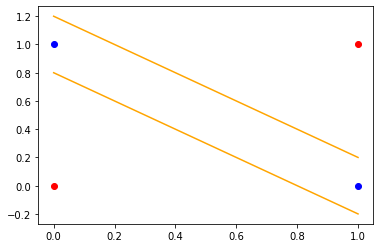

In [3]:
zero_x = [0, 1]
zero_y = [0, 1]
one_x = [0, 1]
one_y = [1, 0]

# Plot XOR-Dots
plt.scatter(zero_x, zero_y, color='red')
plt.scatter(one_x, one_y, color='blue')

plt.plot([0, 1], [0.8, -0.2], color='orange')
plt.plot([0, 1], [1.2, 0.2], color='orange')
plt.show()

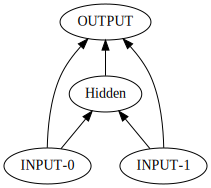

In [4]:
import graphviz

with open("./data/Neuroevolution/XOR-Network.dot") as f:
    solution_network = f.read()

graphviz.Source(solution_network)

## Encoding

- How to represent neural networks such that they …
    1. are modifiable using mutation & crossover
    2. have a consistent mapping from genotype to phenotype 
- __Critical__ decision in every evolutionary algorithm

## Encoding in NEAT

Each genome in NEAT consists of two separate gene lists:
   - Node Genes contain all nodes of a network
   - Connection Genes contain all connections of a network


## Node Genes

Nodes have the following attributes:
 - Unique ID
 - Node type: Input, Bias, Hidden, Output
 - Node value: the weighted sum of all incoming connections
 - Activation value: the value after activating the activation function with the node value as input
 - List of incoming connections

In [5]:
# Basic neuron definition from which all node genes will be derived.
class NodeGene:

    def __init__(self):
        self.uid = 0
        self.type = None
        self.node_value = 0
        self.activation_value = 0
        self.incoming_connections = []

## Input Node

 - Has no activation function

In [6]:
class InputNode(NodeGene):

    def __init__(self, uid: str):
        super().__init__()
        self.uid = uid
        self.type = "INPUT"

    def activate(self):
        self.activation_value = self.node_value
        return self.activation_value

## Bias Node

- Sends a constant signal of 1 into the network without applying any activation function
- Required to have some influence on the [0, 0] input, as otherwise we would always get the same output value regardless of the network structure and weights

In [7]:
class BiasNode(NodeGene):

    def __init__(self, uid: str):
        super().__init__()
        self.uid = uid
        self.type = "BIAS"
        self.node_value = 1
        self.activation_value = 1

    def activate(self):
        return 1

## Hidden Node

- Resides between input and output nodes
- Applies a __steepened__ sigmoid activation function to obtain a precise value distribution in the range [-1, 1]

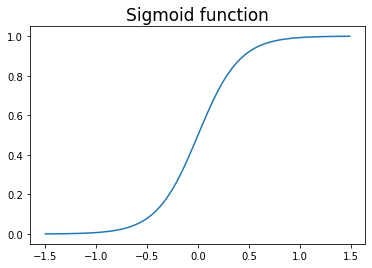

In [8]:
import math
import numpy as np

def sigmoid(x: float):
    return 1 / (1 + math.exp(-4.9*x))   # Steepen factor of -4.9

x_range = np.arange(-1.5, 1.5, 0.01)
sigmoid_values = [sigmoid(x) for x in x_range]
plt.plot(x_range, sigmoid_values)
plt.title('Sigmoid function', fontsize=17)
plt.show()

In [9]:
class HiddenNode(NodeGene):

    def __init__(self, uid: str):
        super().__init__()
        self.uid = uid
        self.type = "HIDDEN"

    def activate(self):
        self.activation_value = sigmoid(self.node_value)
        return self.activation_value

## Output Node

- The activated output of the output node will be treated as network output
- Applies a __steepened__ sigmoid activation function to obtain a precise value distribution in the range [-1, 1]

In [10]:
class OutputNode(NodeGene):

    def __init__(self, uid: str):
        super().__init__()
        self.uid = uid
        self.type = "OUTPUT"

    def activate(self):
        self.activation_value = sigmoid(self.node_value)
        return self.activation_value

To map the activation value of the output node $a \in [0, 1]$ to an XOR-Output $o \in (0, 1)$, we use a simple step function.

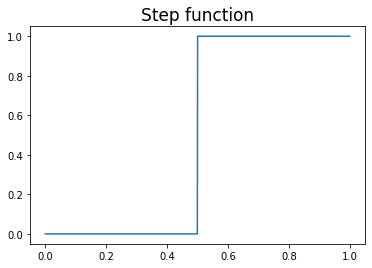

In [11]:
def step_function(x):
    if x>= 0.5:
        return 1
    else:
        return 0
    
x_range = np.arange(0, 1, 0.001)
step_values = [step_function(x) for x in x_range]
plt.plot(x_range, step_values)
plt.title('Step function', fontsize=17)
plt.show()

## Connection Genes

Connection have the following attributes: 
 - Source node 
 - Target node 
 - Weight
 - Enabled state
 - Innovation number: implemented as a counter and used as an identifier (more on that later)

In [12]:
class ConnectionGene:
    innovationCounter = 0
    innovations = {}

    def __init__(self, source: NodeGene, target: NodeGene, weight: float, enabled: bool, innovation: int):
        self.source = source
        self.target = target
        self.weight = weight
        self.enabled = enabled
        self.innovation = innovation

    @staticmethod
    def next_innovation_number():
        ConnectionGene.innovationCounter += 1
        return ConnectionGene.innovationCounter

## Network Chromosome

By combining node and connection genes, we can generate network chromosomes.

In [13]:
class NetworkChromosome:

    def __init__(self, nodes: list[NodeGene], connections: list[ConnectionGene]):
        self.nodes = nodes
        self.connections = connections
        self.input_nodes = []
        self.output_node = []
        self.fitness = 0
        self.shared_fitness = 0
        self.expected_children = 0
        self.parent = False
        self.winner = False
        self.generate()
        
    def generate(self):
        self.input_nodes = [node for node in self.nodes if node.type == 'INPUT']
        self.output_node = next(node for node in self.nodes if node.type == 'OUTPUT')

        # Iterate through the connection gene and add the incoming connections to the target nodes.
        self.connections.sort(key=lambda x: x.innovation)
        for connection in self.connections:
            target_node = connection.target
            if connection not in target_node.incoming_connections and connection.enabled:
                target_node.incoming_connections.append(connection)
        
    def reset(self):
        self.fitness = 0
        self.shared_fitness = 0
        self.parent = False
        self.expected_children = 0
        for node in self.nodes:
            if node.type != "INPUT" and node.type != "BIAS":
                node.activated = False
                node.node_value = 0
                node.activation_value = 0

## Incremental Growth

- NEAT starts with __minimal topologies__ that do __not__ contain any hidden nodes.
- Each input node and the bias node is connected to every output node.
- Random weight initialisation
- Advantages
    - Minimises search space
    - Only useful structures survive during the incremental growth

In [14]:
import random

def get_random_individual():
    # Generate two input, one bias and one output node
    input_nodes = [InputNode(str(x)) for x in range(2)]
    bias_node = BiasNode("2")
    output_node = OutputNode("3")

    # We reset the innovation number, as every network of the starting population
    # has the same historical origins
    innovation = 0
    connections = []
    
    # Connect input nodes
    for i_node in input_nodes:
        connections.append(ConnectionGene(i_node, output_node, random.uniform(-1, 1), True, innovation))
        innovation += 1
    
    # Connect the bias node
    connections.append(ConnectionGene(bias_node, output_node, random.uniform(-1, 1), True, innovation))
    ConnectionGene.innovationCounter = innovation

    return NetworkChromosome(input_nodes + [bias_node, output_node], connections)

We visualise chromosomes using the Graphviz library.

In [15]:
from graphviz import Digraph

class NetworkChromosome(NetworkChromosome):
    def show(self):
        dot = Digraph(graph_attr={'rankdir': 'BT', 'splines': "line"})
        # Make sure input nodes are at the bottom and output nodes at the top by assigning them to subgraphs.
        input_graph = Digraph(graph_attr={'rank': 'min', 'splines': "line"})
        output_graph = Digraph(graph_attr={'rank': 'max', 'splines': "line"})
        hidden_graph = Digraph(graph_attr={'splines': "line"})

        # Add the nodes to the corresponding subgraphs.
        for node in self.nodes:
            if node.type == 'INPUT' or node.type == 'BIAS':
                input_graph.node(node.uid, node.type + "-" + node.uid, color='black', fillcolor='white',
                                 style='filled')
            elif node.type == 'OUTPUT':
                output_graph.node(node.uid, node.type + "-" + node.uid, color='black', fillcolor='white',
                                  style='filled')
            else:
                hidden_graph.node(node.uid, node.type + "-" + node.uid, color='black', fillcolor='white',
                                  style='filled')

        # Combine the subgraphs to a single graph
        dot.subgraph(input_graph)
        dot.subgraph(hidden_graph)
        dot.subgraph(output_graph)

        # Link the nodes based on the connection gene.
        for connection in self.connections:
            style = "solid" if connection.enabled else "dotted"
            dot.edge(connection.source.uid, connection.target.uid, label=str(round(connection.weight, 2)), style=style)
        return dot

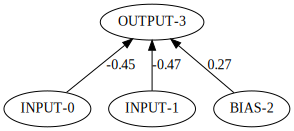

In [16]:
get_random_individual().show()

## Network Activation

We keep sending the input signal into the network until it stabilises.

In [17]:
class NetworkChromosome(NetworkChromosome):

    def activate(self, inputs: [int, int]):
        self.generate()
        self.reset()
        
        stabilise_count = 0
        previous_output = 0
        activation_rounds = 0
        
        for n, i_node in enumerate(self.input_nodes): # Load inputs 
            i_node.node_value = inputs[n]
        
        # Keep sending the input signal into the network until it stabilises for three
        # successive rounds.
        while stabilise_count < 3:
            activation_rounds += 1
            
            # For each node compute the weighted sum of all incoming connections.
            for node in self.nodes:
                if node.type != 'INPUT' and node.type != 'BIAS':
                    node.node_value = 0
                    for connection in node.incoming_connections:
                        if connection.enabled:
                            node.node_value += (connection.weight * connection.source.activate())
            
            # Check if output has stabilised.
            if previous_output == self.output_node.node_value:
                stabilise_count += 1
            else:
                stabilise_count = 0
            previous_output = self.output_node.node_value

            # Sometimes mutation/crossover leads to defect networks.
            if activation_rounds > 100:
                return self.output_node.activate()

        return self.output_node.activate()

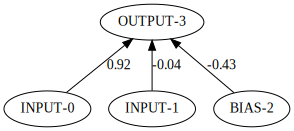

In [18]:
# Allows us to show networks and other output simultanously
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

network = get_random_individual()
inputs = [1, 0]
network.activate(inputs)
network.show()

## Competing Conventions

- Also known as __Permutations Problem__
- Same phenotype can be expressed by __more__ than one genotype
- Risk of information loss during crossover

![Competing Conventions](./data/Neuroevolution/CompetingConventions.png)

## Innovation Numbers

- Neat solves the Competing Conventions problem by introducing __innovation numbers__
- Identifies connection genes through their __historical origin__
- Whenever a __new__ structural change appears due to mutation, a new innovation number has to be assigned
- If the same structural change across several networks is observed, we assign the same innovation number as before

## Crossover

 1. Align the connection genes of both parents
 2. Apply different rules based on the innovation numbers. We differentiate:
    - Matching genes (white) have the same innovation number &rarr; Inherited randomly.
    - Disjoint genes (blue) have diverging innovation numbers within both parents' gene ranges &rarr; Inherited from the more fit parent.
    - Excess genes (red) exceed the connection gene range of the opposing parent &rarr; Inherited from the more fit parent.
    
![Crossover](./data/Neuroevolution/Crossover.png)

We will use a helper function to determine the type of gene pairs

In [19]:
def get_gene_category(parent1: NetworkChromosome, i1: int, parent2: NetworkChromosome, i2: int):
    
    # We have excess genes if a gene iterator exceeds the length of a parents' gene list.
    # Excess genes coming from parent1.
    if i2 >= len(parent2.connections):
        return "EXCESS1"

    # Excess genes from parent 2
    elif i1 >= len(parent1.connections):
        return "EXCESS2"

    # At this point we know that both parents have a connection gene at the current iterator position.
    # To find out whether they are matching or disjoint genes we compare the innovation numbers.
    # If the innovation numbers match, we have matching genes at our hands.
    elif parent1.connections[i1].innovation == parent2.connections[i2].innovation:
        return "MATCH"

    # If they do not match we must have disjoint genes.
    else:
        if parent1.connections[i1].innovation < parent2.connections[i2].innovation:
            return "DISJOINT1"
        else:
            return "DISJOINT2"

In [20]:
import copy

def crossover(parent1: NetworkChromosome, parent2: NetworkChromosome):
    # Sort the connections to line them up appropriately.
    parent1.connections = sorted(parent1.connections, key=lambda x: x.innovation)
    parent2.connections = sorted(parent2.connections, key=lambda x: x.innovation)

    # Determine which parent is more fit.
    if parent1.fitness > parent2.fitness:
        parent1_fitter = True
    elif parent1.fitness < parent2.fitness:
        parent1_fitter = False
    else:
        parent1_fitter = random.choice([True, False])

    child_nodes = []
    child_connections = []

    # Iterators for both parents
    i1 = 0
    i2 = 0

    # Iterate until we reach the end of both connection gene lists.
    while i1 < len(parent1.connections) or i2 < len(parent2.connections):
        connection_to_add = None

        # Determine type of gene pair
        gene_category = get_gene_category(parent1, i1, parent2, i2)

        # Only inherit excess genes from the more fit parent.
        if gene_category == "EXCESS1":
            if parent1_fitter:
                connection_to_add = copy.deepcopy(parent1.connections[i1])
            i1 += 1
        elif gene_category == "EXCESS2":
            if not parent1_fitter:
                connection_to_add = copy.deepcopy(parent2.connections[i2])
            i2 += 1

        # Only inherit disjoint genes from the more fit parent.
        elif gene_category == "DISJOINT1":
            if parent1_fitter:
                connection_to_add = copy.deepcopy(parent1.connections[i1])
            i1 += 1
        elif gene_category == "DISJOINT2":
            if not parent1_fitter:
                connection_to_add = copy.deepcopy(parent2.connections[i2])
            i2 += 1

        # Matching genes are inherited randomly.
        elif gene_category == "MATCH":
            random_connection = random.choice([parent1.connections[i1], parent2.connections[i2]])
            connection_to_add = copy.deepcopy(random_connection)
            i1 += 1
            i2 += 1

        # If we found a connection add it to the child network.
        if connection_to_add is not None:
            child_connections.append(connection_to_add)

            # Check if source node is present in child network.
            if not any(node.uid == connection_to_add.source.uid for node in child_nodes):
                child_nodes.append(connection_to_add.source)

            # Check if target node is present in child network.
            if not any(node.uid == connection_to_add.target.uid for node in child_nodes):
                child_nodes.append(connection_to_add.target)

    return NetworkChromosome(child_nodes, child_connections)

The crossover operator only inherits genes from the more fit parent and discards genes from the less fit parent.

In [21]:
# Add a node to parent 1 to get some diversity between both networks
parent_1 = get_random_individual()
split_connection = parent_1.connections[1] # Choose the first connection and split it
source = split_connection.source
target = split_connection.target

# Create and add the hidden node to the network
hidden = HiddenNode("4")
parent_1.nodes.append(hidden)

# Establish connections between the hidden node and the split connection's source and target nodes
in_connection = ConnectionGene(source, hidden, 1, True, 4)
parent_1.connections.append(in_connection)
out_connection = ConnectionGene(hidden, target, split_connection.weight, True, 5)
parent_1.connections.append(out_connection)
parent_1.generate()

parent_2 = get_random_individual()

Parent 1


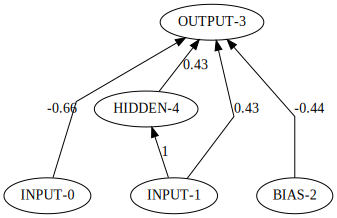

Parent 2


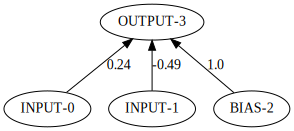

Crossover Child


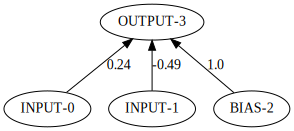

In [22]:
# Change fitness to see the more fit parent prevail.
parent_1.fitness = 5
parent_2.fitness = 5
print("Parent 1")
parent_1.show()
print("Parent 2")
parent_2.show()

print("Crossover Child")
crossover(parent_1, parent_2).show()

## Mutation

   - Structural mutations change the structure of a network and lead to new innovation numbers:
        - Add Node Mutation: Adds a new node to the network by placing the new node inbetween an existing connection
        - Add Connection Mutation: Adds a new connection between currently disconnected nodes
   - Non-Structural mutations change non-structural attributes of the network and do __not__ introduce novel innovation numbers:
        - Weight Mutation: Mutate all weights of a network
        - Enabled Mutation: Toggles the enable state of a randomly chosen connection

## Add Node Mutation
 - Adds a hidden node to the network by splitting an existing connection
 - __Source Node &rarr; new node__: connection obtains a weight of 1
 - __New node &rarr; target node__: connection inherits the old connection value
 - Reasoning of weight distribution is to keep the influence of the new node as small as possible
 - For the two new connections, we have to check whether the same structural change has already occurred in the past when assigning an innovation number

In [23]:
import re

def add_node(chromosome: NetworkChromosome, current_innovations:dict):
    # Pick a random connection inbetween which the new node will we placed. The old connection is disabled.
    split_connection = random.choice(chromosome.connections)
    split_connection.enabled = False
    source = split_connection.source
    target = split_connection.target

    # Create the hidden node; as an id we concatenate the source node id with the target node id.
    uid = source.uid + target.uid
    regex = re.compile(uid+"-[0-9]*")
    uid += str(sum(1 for node in chromosome.nodes if regex.match(node.uid)))
    hidden = HiddenNode(uid)
    chromosome.nodes.append(hidden)

    # Check if we have previously seen a structural change between source -> hidden.
    innovation_key = source.uid + "-" + hidden.uid
    if innovation_key not in current_innovations:
        current_innovations[innovation_key] = ConnectionGene.next_innovation_number()
        
    # Source -> hidden gets a weight of 1.
    in_connection = ConnectionGene(source, hidden, 1, True, current_innovations[innovation_key])
    chromosome.connections.append(in_connection)

    # Check if we have previously seen a structural change between hidden -> target.
    innovation_key = hidden.uid + "-" + target.uid
    if innovation_key not in current_innovations:
        current_innovations[innovation_key] = ConnectionGene.next_innovation_number()
        
    # Hidden -> target gets the same weight as the old connection.
    out_connection = ConnectionGene(hidden, target, split_connection.weight, True, current_innovations[innovation_key])
    chromosome.connections.append(out_connection)

Original


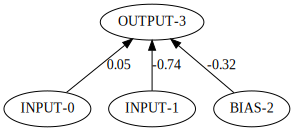

Node mutation


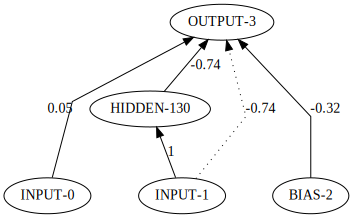

In [24]:
print("Original")
network = get_random_individual()
network.show()
print("Node mutation")
add_node(network, {})
network.show()

## Add Connection Mutation

- Add a new connection between two previously disconnected nodes
- Do not allow connections leading into the bias and input nodes since we do not want to change their node values
- Do not allow connections leading out of the output node to limit the development of recurrent connections
- Do not allow self-loops to limit the development of recurrent connections
- Since we add novel structure to the network, we again have to assign an innovation number

In [25]:
def add_connection(chromosome: NetworkChromosome, current_innovations: dict):
    # Collect all feasible source & target nodes.
    target_nodes = [node for node in chromosome.nodes if node.type != 'INPUT' and node.type != 'BIAS']
    source_nodes = [node for node in chromosome.nodes if node.type != 'OUTPUT']

    # Pick a random source and target node and check whether the resulting connection is valid.
    tries = 0
    found = False
    while tries < 10 and not found:
        source = random.choice(source_nodes)
        target = random.choice(target_nodes)

        # We do not allow self loops
        if source == target:
            tries += 1
            continue

        # Check if we actually found a novel connection.
        found = True
        for connection in chromosome.connections:
            if connection.source.uid == source.uid and connection.target.uid == target.uid:
                tries += 1
                found = False
                break

        # At this point we found a valid node pair and add the connection to the network.
        if found:
            # Assign innovation number.
            innovation_key = source.uid + "-" + target.uid
            if innovation_key not in current_innovations:
                current_innovations[innovation_key] = ConnectionGene.next_innovation_number()
                
            # Add connection to network
            new_connection = ConnectionGene(source, target, random.uniform(-1, 1), True, current_innovations[innovation_key])
            chromosome.connections.append(new_connection)
            chromosome.generate()

Parent


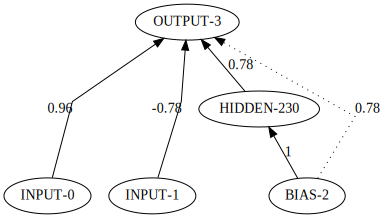

Connection mutation


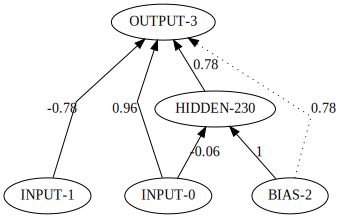

In [26]:
print("Parent")
network = get_random_individual()
add_node(network, {})
network.show()
print("Connection mutation")
add_connection(network, {})
network.show()

## Mutate Weight Mutation
- The weight mutation modifies every connection weight of a network
- Probability of 90%: uniformly pick a value in the range of [-1, 1] and add it to the connection weight
- Probability of 10%: assign a new weight by uniformly selecting a value in the range [-1, 1]

In [27]:
def mutate_weight(chromosome: NetworkChromosome):
    for connection in chromosome.connections:
        if random.random() < 0.9:
            connection.weight += random.uniform(-1, 1)
        else:
            connection.weight = random.uniform(-1, 1)

Original


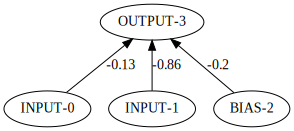

Weight Mutation


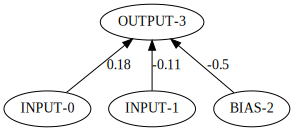

In [28]:
network = get_random_individual()
print("Original")
network.show()
print("Weight Mutation")
mutate_weight(network)
network.show()

## Toggle Connection Mutation
- Picks a random connection and toggles its enabled state
- __Attention!__ The mutation may lead to defect networks if the resulting network does not have an enabled path from an input or bias node to the output node.

In [29]:
def toggle_connection(chromosome: NetworkChromosome):
    # Pick a random connection and toggle the enable state
    connection = random.choice(chromosome.connections)
    connection.enabled = not connection.enabled

Original


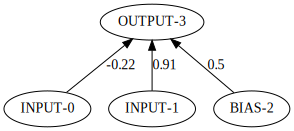

Toggle Connection Mutation


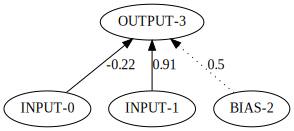

In [30]:
print("Original")
network = get_random_individual()
network.show()
print("Toggle Connection Mutation")
toggle_connection(network)
network.show()

## Global Mutation Function
- All mutations are combined to a single mutation function
- Structural mutations are applied with a probability of 3% (add node mutation) or 5% (connection mutation)
- If no structural mutation has been applied we toggle the enable state of a connection (10%) or change the connection weights (90%)
- Structural and non-structural mutations are not applied in combination to reduce the impact of mutation

In [31]:
def mutate(chromosome: NetworkChromosome, current_innovations: dict):
    mutant = copy.deepcopy(chromosome)

    # Structural mutations
    if random.random() < 0.03:
        add_node(mutant, current_innovations)
    elif random.random() < 0.05:
        add_connection(mutant, current_innovations)

    # Non-Structural mutations
    else:
        if random.random() < 0.1:
            toggle_connection(mutant)
        else:
            mutate_weight(mutant)

    mutant.reset() # Reset the mutant's attributes
    return mutant

## Protecting Innovation

- Novel network structures usually perform worse than established ones since their connection weights have not been updated yet to suit the new network architecture.
- Novel structures may still be a crucial step towards finding a novel solution
- __Idea__: protect novel structures for some generations to give them time to optimise their weights &rarr; Speciation

## Speciation

- Separates the whole population into distinct species having similar network structures
- Networks primarily only have to compete within their species, which gives them time to optimise their connection weights
- __Problem__: we could still get a single species that dominates all other species, eventually leading to a single species with an established network structure and no room for innovation
- __Solution__: fitness sharing &rarr; every network $n$ of a species has to share its fitness $f_n$ with all members of the same species: $$ f'_n = \frac{f_n}{size(Species)} $$
<p></p>

- __Effect__: large species are penalised, allowing smaller species to grow
- As soon as a species has not shown any signs of improvements for 15 generations, we penalise the species &rarr; species eventually goes extinct and leaves room for other more promising species

In [32]:
class Species:
    penalising_age = 15
    penalising_factor = 0.0001

    def __init__(self, population: list[NetworkChromosome]):
        self.population = population
        self.last_improved_counter = 1       # Number of generations without improvements
        self.best_fitness = 0
        self.expected_children = 0

    def share_fitness(self):
        # Update the counter for penalising stale species
        self.population = sorted(self.population, key=lambda x: x.fitness, reverse=True)
        if self.population[0].fitness > self.best_fitness:
            self.best_fitness = self.population[0].fitness
            self.last_improved_counter = 0
        else:
            self.last_improved_counter += 1

        # Share fitness or penalise the species
        for network in self.population:
            if self.last_improved_counter >= Species.penalising_age:
                network.shared_fitness = network.fitness * Species.penalising_factor
            else:
                network.shared_fitness = network.fitness / len(self.population)

## Compatibility Distance

- Measure of similarity between networks
- Determines whether two networks should belong to the same species
- Linear combination of the number of excess genes $(E)$, the number of disjoint genes $(D)$ and the average weight difference of matching genes $(W)$: $$\delta = c_1*E + c_2*D + c_3 * W$$
- $c_1, c_2, c_3$ weight the importance of the three gene categories

In [33]:
def compatibility_distance(network_1: NetworkChromosome, network_2: NetworkChromosome):
    excess = 0 # Excess counter
    disjoint = 0 # Disjoint counter
    matching = 0 # Matching counter
    weight_difference = 0
    i1 = 0
    i2 = 0

    while i1 < len(network_1.connections) or i2 < len(network_2.connections):
        gene_category = get_gene_category(network_1, i1, network_2, i2)
        if gene_category == "EXCESS1":
            i1 += 1
            excess += 1
        elif gene_category == "EXCESS2":
            i2 += 1
            excess += 1

        elif gene_category == "DISJOINT1":
            i1 += 1
            disjoint += 1
        elif gene_category == "DISJOINT2":
            i2 += 1
            disjoint += 1

        elif gene_category == "MATCH":
            matching += 1
            weight_difference += abs(network_1.connections[i1].weight - network_2.connections[i2].weight)
            i1 += 1
            i2 += 1

    # Specify the weight coefficients.
    # We weight disjoint and excess genes twice as important as weight differences.
    c1 = 1
    c2 = 1
    c3 = 0.5

    if matching == 0:
        return (c1 * excess) + (c2 * disjoint)
    else:
        return (c1 * excess) + (c2 * disjoint) + (c3 * weight_difference / matching)

In [34]:
print("Networks having the same network structure have a low compatibility distance: ")
network_1 = get_random_individual()
network_2 = get_random_individual()
compatibility_distance(network_1, network_2)

print("Adding a node to one of the networks leads to diverging network structures and therefore a higher compatibility distance:")
add_node(network_1, {})
compatibility_distance(network_1, network_2)

Networks having the same network structure have a low compatibility distance: 


0.43592962668936436

Adding a node to one of the networks leads to diverging network structures and therefore a higher compatibility distance:


2.435929626689364

## Assigning Networks to a Species

- A compatibility threshold $\delta_t$ determines whether two networks should belong to the same species
- If the compatibility distance of two networks is smaller than the threshold $\delta < \delta_t$, both networks should belong to the same species

In [35]:
def speciate(network: NetworkChromosome, species_list: list[Species], threshold):
    # If there are no species, we creating the first one.
    if len(species_list) == 0:
        species = Species([network])
        species_list.append(species)

    # Otherwise, try to find a compatible species by traversing the list of species.
    else:
        for specie in species_list:
            if len(specie.population) > 0:
                representative = random.choice(specie.population)
                compatibility = compatibility_distance(representative, network)
                if compatibility < threshold:
                    specie.population.append(network)
                    return

        # At this point we were not able to find a compatible species.
        # Thus, we create a new species for the given network.
        species = Species([network])
        species_list.append(species)

## Updating the Compatiblity Threshold

- __Problem__: Difficult to define a compatibility threshold upfront for a given problem (No Free Lunch Theorem)
- __Solution__: Update the threshold towards the desired numer of species

In [36]:
def update_compat_threshold(threshold, number_species, target_size):
    #If we have too many species, increase the threshold.
    if number_species > target_size:
        threshold += 0.3
        
    # If we have too few species, decrease the threshold.
    elif number_species < target_size:
        threshold -= 0.3

    # Make sure the threshold does not shrink below the update value of 0.3.
    if threshold < 0.3:
        threshold = 0.3
    return threshold

## Evolution within Species

- NEAT evolves networks within species
- The number of children each species is allowed to generate is determined by the sum of the number of children $n_c$ each __member__ of the species is allowed to produce: $$n_c = \frac{network.sharedFitness}{averageSharedFitness} $$ with $averageSharedFitness$ referring to the average shared fitness score across all networks of the population

In [37]:
def assign_children_to_species(species_list: list[Species], population_size: int):
    
    # Calculate the shared fitness value of each network
    # and the average shared fitness across all networks.
    avg_shared_fitness = 0
    for species in species_list:
        species.share_fitness()
        avg_shared_fitness += sum(network.shared_fitness for network in species.population)
    avg_shared_fitness /= population_size

    # Determine how many children each network is allowed to produce.
    child_sum = 0
    left_over = 0
    for species in species_list:
        for network in species.population:
            network.expected_children = network.shared_fitness / avg_shared_fitness
            
        # Determine how many children each species is allowed to produce
        left_over = species.calculate_expected_children(left_over)
        child_sum += species.expected_children

    # Due to rounding we may loose some children.
    # To keep a steady population size we assign the lost children to the best performing species
    species_list = sorted(species_list, key=lambda species: species.expected_children, reverse=True)
    if child_sum < population_size:
        species_list[0].expected_children += population_size - child_sum

During the calculation of the number of children a given species is allowed to produce, we have to keep track of fractions to not shrink in population size

In [38]:
class Species(Species):
    def calculate_expected_children(self, left_over):
        self.expected_children = 0

        for network in self.population:
            # Floor to integer but save the lost fraction.
            whole_child = math.floor(network.expected_children)
            fraction_child = network.expected_children % 1

            self.expected_children += whole_child
            left_over += fraction_child

            # If our fractions accumulate to a whole child, we add it to the species' expected children.
            if left_over > 1:
                self.expected_children += math.floor(left_over)
                left_over -= math.floor(left_over)

        # Reuse the fraction for the next species to not shrink in population size.
        return left_over

20% of the best-performing networks of a species will serve as parent candidates

In [39]:
class Species(Species):
    parent_rate = 0.2

    def define_parents(self):
        # Sort the population according to the network's fitness values in decreasing order
        # and mark potential parents.
        self.population = sorted(self.population, key=lambda x: x.fitness, reverse=True)
        number_parents = math.floor(Species.parent_rate * len(self.population))
        number_parents = 1 if number_parents < 1 else number_parents  # Mark at least one network as parent
        for network in self.population[0:number_parents]:
            network.parent = True

We evolve networks within species by
 1. always cloning the best-perform network once
 2. applying mutation with a probability of 75% to randomly chosen parent candidates
 3. applying crossover with a probability of 25% to randomly chosen parent candidates (if there are at least two)

In [40]:
class Species(Species):
    mutation_rate = 0.75 
    
    def evolve(self):
        # Determine potential parents and remove all non-parents.
        self.define_parents()
        self.population = [network for network in self.population if network.parent]

        # If we don't have any parents or don't expect any children stop.
        if len(self.population) == 0 or self.expected_children < 1:
            return []

        # Keep generating children until we've reached the desired number of children.
        children = []
        while len(children) < self.expected_children:

            # Elitism: in the first iteration, we clone the species champion.
            if len(children) == 0:
                champion_child = copy.deepcopy(self.population[0])
                champion_child.reset()
                children.append(champion_child)

            # Apply mutation if we only have a single parent or with a given probability.
            elif random.random() < Species.mutation_rate or len(self.population) == 1:
                parent = random.choice(self.population)
                children.append(mutate(parent, ConnectionGene.innovations))
                
            # Otherwise, apply crossover
            else:
                parent_1, parent_2 = random.sample(self.population, 2)
                children.append(crossover(parent_1, parent_2))
                
        return children

## Global Evolution

1. Define the number of children each species is allowed to generate
2. Trigger the evolution process within species
3. Remove extinct species and parents

In [41]:
def evolve_population(species_list: list[Species], population_size: int, compat_threshold: int):
    
    # Assign the number of children each species is allowed to produce
    assign_children_to_species(species_list, population_size)

    # Evolve networks within their species.
    children = []
    for species in species_list:
        children += species.evolve()

    # Assign the new children to species.
    for child in children:
        speciate(child, species_list, compat_threshold)

    # Remove species that went extinct and eliminate parents.
    for species in species_list:
        species.population = [network for network in species.population if network in children]
    species_list = [species for species in species_list if len(species.population) > 0]
    return species_list

## Fitness Function

- Should determine how close a network is to solve the XOR-Problem
- __Nice to have__: error gradient upon which the search can improve
- Sequentially ask the network for the output of all four input combinations and calculate the error between the network's actual output and the intended XOR output
- Cast to maximisation problem by calculating the squared error between the error value and maximum achievable fitness of four

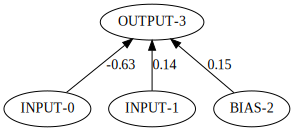

Fitness: 5.834063054790624


In [42]:
from statistics import mean

def get_fitness_network(network: NetworkChromosome):
    error = 0
    for index, row in xor_df.iterrows():
        xor_input = [row["Input1"], row["Input2"]]
        xor_output = row["Output"]
        network_output = network.activate(xor_input)
        if step_function(network_output) != xor_output:
            error += abs(xor_output - network_output)

    network.fitness = (4 - error) ** 2
    return network.fitness

network = get_random_individual()
network.show()
print("Fitness: " + str(get_fitness_network(network)))

We will use a helper function to evaluate the entire population.

In [43]:
def get_fitness_population(species_list: list[Species]):
    best_fitness = 0
    best_network = None
    for specie in species_list:
        for network in specie.population:
            fitness = get_fitness_network(network)

            # Record the best network
            if fitness > best_fitness:
                best_fitness = fitness
                best_network = network

            # If we found a solution stop, and return the solution.
            if fitness == 16:
                best_network.winner = True
                return best_network
    return best_network

## Solving the XOR-Problem via NEAT

1. Generate the initial population
2. Enter search loop
        2.1 Update compatibility threshold
        2.2 Evaluate networks
        2.3 Check if we have found a solution
        2.4 Evolve the population

In [44]:
def solve_xor(iteration = 0, population_size = 150, log_interval = 10,
              compat_threshold = 3, target_species_size = 5):

    # Generate the initial population.
    species_list = []
    for _ in range(population_size):
        speciate(get_random_individual(), species_list, compat_threshold)

    # Start the search for a solution.
    best_fitness = []
    number_generations = 0
    while number_generations < 100:

        # Update compatibility threshold
        compat_threshold = update_compat_threshold(compat_threshold, len(species_list), target_species_size)

        # Evaluate all networks and save the fitness of the best performing network.
        best_network = get_fitness_population(species_list)
        best_fitness.append(best_network.fitness)

        # Every x generations we print a status update of the search.
        if number_generations % log_interval == 0:
            print("------------ Generation " + str(number_generations) + "-------------------")
            print("Current Fitness: " + str(best_network.fitness))
            print("Total Population Count: " + str(sum(len(species.population) for species in species_list)))
            print("Number of Species: " + str(len(species_list)))

        # If we found a solution; stop and save the network.
        if best_network.winner:
            print("Found solution in generation ", str(number_generations))
            with open('./data/Neuroevolution/Winner-' + str(iteration) + '.dot', 'w') as current_network:
                current_network.write(best_network.show().source)
            current_network.close()
            return best_fitness

        # If we didn't find a solution evolve the networks fo form the next generation.
        species_list = evolve_population(species_list, population_size, compat_threshold)
        number_generations += 1

    return best_fitness

------------ Generation 0-------------------
Current Fitness: 10.830063038859638
Total Population Count: 150
Number of Species: 1
------------ Generation 10-------------------
Current Fitness: 11.211699576307245
Total Population Count: 150
Number of Species: 6
------------ Generation 20-------------------
Current Fitness: 11.255239357373892
Total Population Count: 150
Number of Species: 7
------------ Generation 30-------------------
Current Fitness: 12.08624872776107
Total Population Count: 150
Number of Species: 4
------------ Generation 40-------------------
Current Fitness: 11.826927549269463
Total Population Count: 150
Number of Species: 5
------------ Generation 50-------------------
Current Fitness: 11.831376210311682
Total Population Count: 150
Number of Species: 4
------------ Generation 60-------------------
Current Fitness: 11.832303050956208
Total Population Count: 150
Number of Species: 5
------------ Generation 70-------------------
Current Fitness: 12.0126982412153
Total

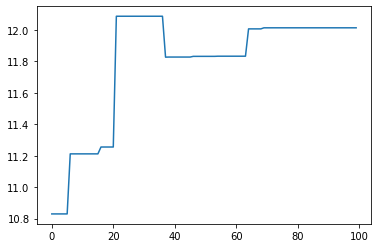

In [45]:
fitness_values = solve_xor()
x_range = np.arange(0, len(fitness_values), 1)

plt.plot(x_range, fitness_values)

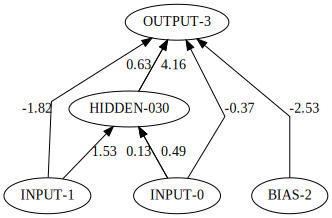

In [46]:
import graphviz

with open("./data/Neuroevolution/Winner-0.dot") as f:
    solution_network = f.read()

graphviz.Source(solution_network)

# Evaluation

We repeat the experiment for a couple of times and report the following values: 
 - How often did we find a solution?
 - On average how many generations are required to find a solution
 - Fitness over Generations
 
Depending on the number of repetitions, this may take some time...

------------ Generation 0-------------------
Current Fitness: 9.936965309356127
Total Population Count: 150
Number of Species: 1
------------ Generation 10-------------------
Current Fitness: 10.77135087973202
Total Population Count: 150
Number of Species: 8
------------ Generation 20-------------------
Current Fitness: 12.086302732546159
Total Population Count: 150
Number of Species: 8
------------ Generation 30-------------------
Current Fitness: 12.08632753678897
Total Population Count: 150
Number of Species: 6
------------ Generation 40-------------------
Current Fitness: 11.690692227071953
Total Population Count: 150
Number of Species: 4
------------ Generation 50-------------------
Current Fitness: 11.707811165842532
Total Population Count: 150
Number of Species: 2
------------ Generation 60-------------------
Current Fitness: 11.707817337077763
Total Population Count: 150
Number of Species: 7
------------ Generation 70-------------------
Current Fitness: 12.040215138670128
Total

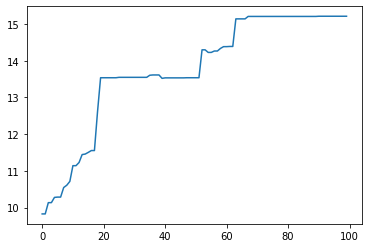

In [47]:
repetitions = 5
fitness_values = [solve_xor(x) for x in range(repetitions)]
iterations = [len(fitness_vals) for fitness_vals in fitness_values]

# Padding for the plot.
for fitness in fitness_values:
    while len(fitness) < 100:
        fitness += [16]

mean_fitness_per_time = np.array(fitness_values).mean(axis=0)
x_range = np.arange(0, 100, 1)

print("---------------------------------------")
print("Found Solutions: " + str(sum(1 if iterations < 100 else 0 for iterations in iterations)))
print("Average number of generations: " + str(mean(iterations)))
plt.plot(x_range, mean_fitness_per_time)